Temperatures taken from this website:  
https://www.historique-meteo.net/france/rh-ne-alpes/lyon/

This dataset is updated monthly to be updated early september with august temeratures (to be updated in early september with august temeratures).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## Import and inspect the data

In [2]:
# url = 'https://www.historique-meteo.net/site/export.php?ville_id=201'
df = pd.read_csv('./data/export-lyon.csv', header=3, parse_dates=['DATE'], index_col='DATE')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3530 entries, 2009-01-01 to 2018-08-31
Data columns (total 18 columns):
MAX_TEMPERATURE_C         3530 non-null int64
MIN_TEMPERATURE_C         3530 non-null int64
WINDSPEED_MAX_KMH         3530 non-null int64
TEMPERATURE_MORNING_C     3530 non-null int64
TEMPERATURE_NOON_C        3530 non-null int64
TEMPERATURE_EVENING_C     3530 non-null int64
PRECIP_TOTAL_DAY_MM       3530 non-null float64
HUMIDITY_MAX_PERCENT      3530 non-null int64
VISIBILITY_AVG_KM         3530 non-null float64
PRESSURE_MAX_MB           3530 non-null int64
CLOUDCOVER_AVG_PERCENT    3530 non-null float64
HEATINDEX_MAX_C           3530 non-null int64
DEWPOINT_MAX_C            3530 non-null int64
WINDTEMP_MAX_C            3530 non-null int64
WEATHER_CODE_MORNING      3530 non-null int64
WEATHER_CODE_NOON         3530 non-null int64
WEATHER_CODE_EVENING      3530 non-null int64
OPINION                   3530 non-null object
dtypes: float64(3), int64(14), object(1)

What we are most interested in are min/max temperatures:

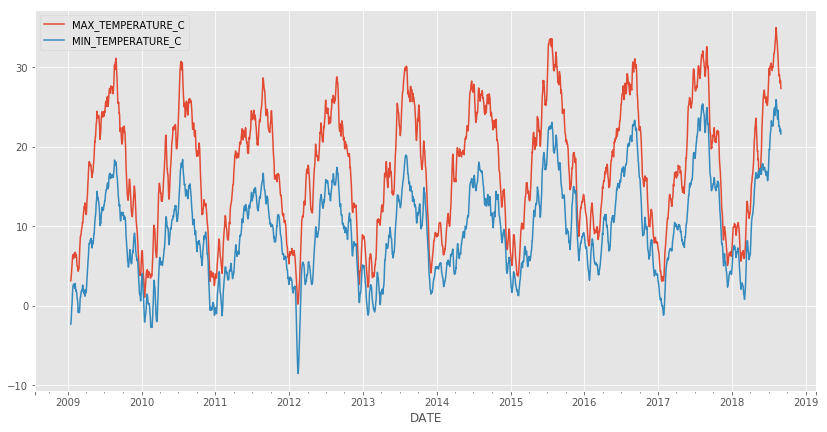

In [3]:
n_days = 15
win_type = None
df[['MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C']].rolling(window=n_days, win_type=win_type).mean().plot(figsize=(14, 7))

## Heat wave and warm day definitions

> Meteorological services warn that there is a risk of heatwave when for at least three days, minimum temperatures, especially at night, are above 20 °C and maximum temperatures above 33 °C.

From [here](https://www.futura-sciences.com/planete/definitions/climatologie-canicule-6521/) (in french).  

So let's define a warm day to have `MAX_TEMPERATURE_C >= 33` and `MIN_TEMPERATURE_C >= 20`. A heat wave is made of at least 3 consecutive warm days.

## Number of warm days per year

In [4]:
df['WARM_DAY'] = False
df.loc[(df.MAX_TEMPERATURE_C >= 33) & (df.MIN_TEMPERATURE_C >= 20), 'WARM_DAY'] = True

In [5]:
print(len(df[df.WARM_DAY]), 'warm days between', df.index[0].date(), 'and', df.index[-1].date())

107 warm days between 2009-01-01 and 2018-08-31


Text(0,0.5,'Number of warm days per year')

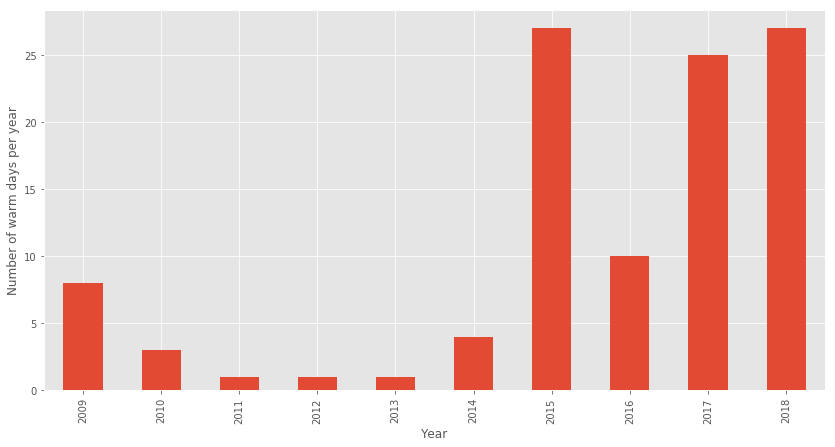

In [6]:
yearly_count = df['WARM_DAY'].resample('Y').sum().to_frame()
yearly_count['year'] = yearly_count.index.year
yearly_count.set_index('year', inplace=True)
yearly_count.plot.bar(figsize=(14, 7), legend=False)
plt.xlabel("Year")
plt.ylabel("Number of warm days per year")

## Number of high heat index days per year ("apparent temperature")

Effects of the heat index from [wikipedia](https://en.wikipedia.org/wiki/Heat_index):

| Heat Index | Effect |
|--- | --- |
| 27–32 °C | Caution: fatigue is possible with prolonged exposure and activity. Continuing activity could result in heat cramps. |
| 32–41 °C | Extreme caution: heat cramps and heat exhaustion are possible. Continuing activity could result in heat stroke. |
| 41–54 °C | Danger: heat cramps and heat exhaustion are likely; heat stroke is probable with continued activity. |
| over 54 °C | Extreme danger: heat stroke is imminent. |

In [7]:
df['WARM_DAY_HI_27-31'] = False
df['WARM_DAY_HI_32-40'] = False
df['WARM_DAY_HI_over_41'] = False
df.loc[(df.HEATINDEX_MAX_C >= 27) & (df.HEATINDEX_MAX_C < 32), 'WARM_DAY_HI_27-31'] = True
df.loc[(df.HEATINDEX_MAX_C >= 32) & (df.HEATINDEX_MAX_C < 41), 'WARM_DAY_HI_32-40'] = True
df.loc[df.HEATINDEX_MAX_C >= 41, 'WARM_DAY_HI_over_41'] = True

In [8]:
yearly_count_HI = df[['WARM_DAY_HI_27-31', 'WARM_DAY_HI_32-40', 'WARM_DAY_HI_over_41']].resample('Y').sum()
yearly_count_HI['year'] = yearly_count_HI.index.year
yearly_count_HI.set_index('year', inplace=True)

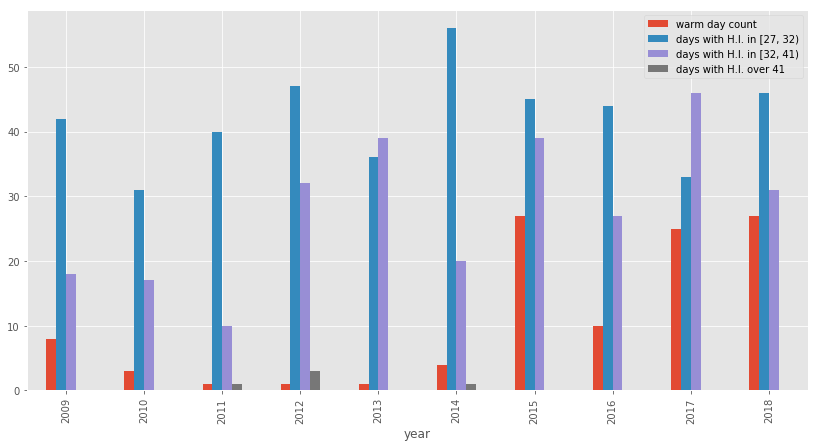

In [9]:
renaming = {'WARM_DAY': 'warm day count', 
            'WARM_DAY_HI_27-31': 'days with H.I. in [27, 32)',
            'WARM_DAY_HI_32-40': 'days with H.I. in [32, 41)',
            'WARM_DAY_HI_over_41': 'days with H.I. over 41'}
pd.merge(yearly_count, yearly_count_HI, on='year').rename(renaming, axis=1).plot.bar(figsize=(14, 7))

It is rather difficult to use the heat index because it may differ a lot from the temperature (https://xkcd.com/2026/). Let us stick to the min/max temperatures.  


<img src="https://imgs.xkcd.com/comics/heat_index.png"
     alt="xkcd cartoon"
     style="float: left; margin-right: 10px;" />

## Longest heat wave per year

In [10]:
def count_contiguous_warm_days(vec):

    CONT_WARM_DAYS = np.zeros(vec.shape[0], dtype=int)
    count = 0
    for i in range(1, vec.shape[0]):
        if vec[i] == 1:
            count += 1
            CONT_WARM_DAYS[i] = count
        else:
            count = 0
    for i in range(vec.shape[0]-2, -1, -1):
        if CONT_WARM_DAYS[i] > 0:
            if CONT_WARM_DAYS[i+1] > 0:
                CONT_WARM_DAYS[i] = CONT_WARM_DAYS[i+1]
    
    return CONT_WARM_DAYS

In [11]:
df['CONT_WARM_DAYS'] = count_contiguous_warm_days(df.WARM_DAY.values)

In [12]:
longest_heatwave = df['CONT_WARM_DAYS'].resample('Y').max().fillna(0).to_frame()
longest_heatwave['year'] = longest_heatwave.index.year
longest_heatwave.set_index('year', inplace=True)

Text(0,0.5,'Longest heat wave per year (days)')

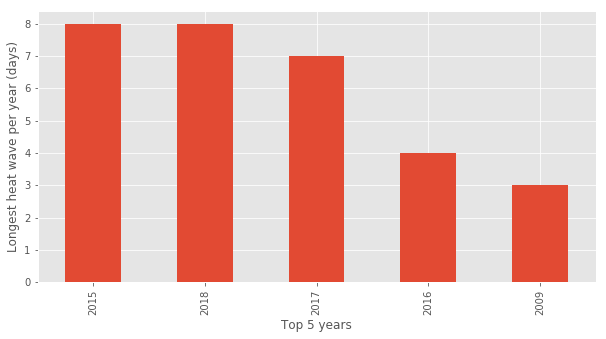

In [13]:
longest_heatwave.sort_values('CONT_WARM_DAYS', ascending=False)[:5].plot.bar(figsize=(10, 5), legend=False)
plt.xlabel("Top 5 years")
plt.ylabel("Longest heat wave per year (days)")

## Cumulative number of heat wave days per year

Here we only consider days in heat waves (with at least 3 consecutive warm days).

In [14]:
title = 'Cumulative number of heat wave days'
heatwave_days = df[df.CONT_WARM_DAYS >= 3].CONT_WARM_DAYS.resample('Y').count()
heatwave_days.name = title
heatwave_days = heatwave_days.to_frame()
heatwave_days['year'] = heatwave_days.index.year
heatwave_days.set_index('year', inplace=True)

Text(0,0.5,'Cumulative number of heat wave days')

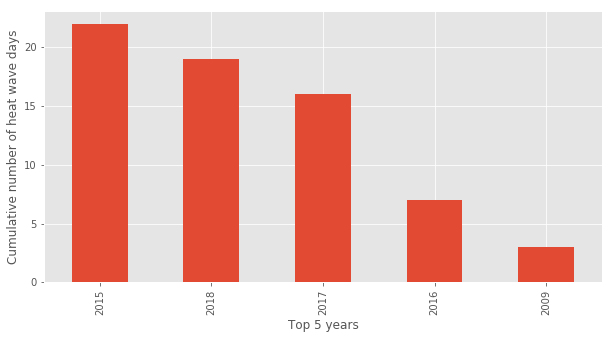

In [15]:
heatwave_days.sort_values(title, ascending=False)[:5].plot.bar(figsize=(10, 5), legend=False)
plt.xlabel("Top 5 years")
plt.ylabel(title)

## Peak temperature

In [16]:
yearly_peak = df['MAX_TEMPERATURE_C'].resample('Y').max().to_frame()
yearly_peak['year'] = yearly_peak.index.year
yearly_peak.set_index('year', inplace=True)

Text(0,0.5,'Peak temperature')

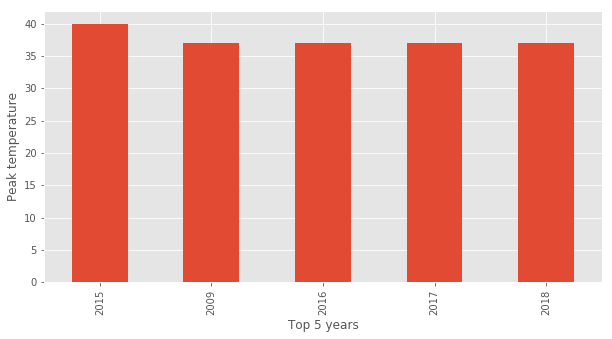

In [17]:
yearly_peak.sort_values("MAX_TEMPERATURE_C", ascending=False)[:5].plot.bar(figsize=(10, 5), legend=False)
plt.xlabel("Top 5 years")
plt.ylabel("Peak temperature")

## Average temperature in June, July and August

The formula used to compute the monthly temperature is not very sophisticated... We take the mean of the min and max temperature over the month.

In [18]:
df_month = df[['MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C']].resample('M').mean()
df_month['MEAN_TEMP'] = df_month.mean(axis=1)
df_month['year'] = df_month.index.year
df_month['month'] = df_month.index.month

In [19]:
df_june = df_month[df_month.month==6][['year', 'MEAN_TEMP']]
df_july = df_month[df_month.month==7][['year', 'MEAN_TEMP']]
df_august = df_month[df_month.month==8][['year', 'MEAN_TEMP']]

Text(0,0.5,'Mean temperature of the summer months')

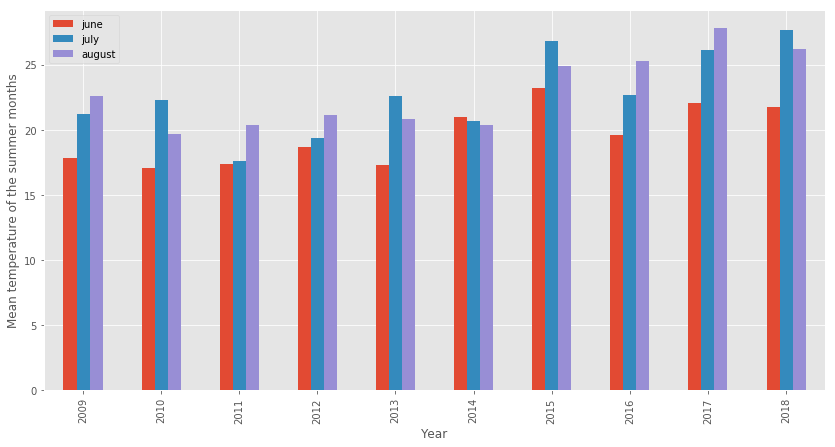

In [20]:
df_summer_months = pd.DataFrame({'june': df_june.MEAN_TEMP.values}, index=df_june.year.values)
df_summer_months = df_summer_months.join(df_july.rename({'MEAN_TEMP': 'july'}, axis=1).set_index('year'))
df_summer_months = df_summer_months.join(df_august.rename({'MEAN_TEMP': 'august'}, axis=1).set_index('year'))
df_summer_months.plot.bar(figsize=(14, 7))
plt.xlabel("Year")
plt.ylabel("Mean temperature of the summer months")

## Conclusion

This month of July was hot...